In [26]:
import math
import numpy as np
import pandas as pd
import shapely
import matplotlib
from matplotlib import pylab as plt
import geopandas as gpd
import pyproj
import contextily as ctx
from time import perf_counter
from copy import deepcopy

from shapely.geometry import Point, LineString, MultiPoint, Polygon, GeometryCollection
from shapely.ops import unary_union, nearest_points
from shapely.wkt import loads as wkt_load

from queue import PriorityQueue
from collections import defaultdict
from math import sqrt

crs_gps = pyproj.CRS.from_epsg('4326') # WGS84 Merkator (degrees)
crs_web = pyproj.CRS.from_epsg('3857') # Pseudo-Merkator (meters)
crs_est = pyproj.CRS.from_epsg('3301') # Estonian Coordinate System

# https://epsg.io/transform#s_srs=4326&t_srs=3301 - used this to convert from gps to estonian coordinate system
# needed to invert latitude and longitude
delta = Point(659351.9779390106, 6474942.48407838)
lounakeskus = Point(656661.9914198933, 6471868.239886967)
sirius = Point(659234.2258483924, 6471525.160984464)
ihaste = Point(663231.1552057452, 6471198.855079322)
kvissental = Point(657392.1712729766, 6477063.679848602)

In [27]:
data = pd.read_csv("data/driveways_cleaned.csv", index_col="global_id")
data["geometry"] = data["geometry"].apply(wkt_load)
gdf_data = gpd.GeoDataFrame(data, geometry="geometry", crs=crs_est)
# Remove 3 instances of MultiLineStrings (they don't allow for coords)
gdf_data = gdf_data[gdf_data.geometry.geom_type == "LineString"]
gdf_data["start_node_x"] = gdf_data.geometry.apply(lambda row: round(row.coords[0][0],3))
gdf_data["start_node_y"] = gdf_data.geometry.apply(lambda row: round(row.coords[0][1],3))
gdf_data["end_node_x"] = gdf_data.geometry.apply(lambda row: round(row.coords[-1][0],3))
gdf_data["end_node_y"] = gdf_data.geometry.apply(lambda row: round(row.coords[-1][1],3))
gdf_data.head()

# defaultdict of start nodes that points to a defaultdict of end nodes that points to a tuple that ->
# -> contains the distance of the end node and the global id of the road one should take
graph = defaultdict(lambda: defaultdict( lambda: [math.inf, None]))

for index, row in gdf_data.iterrows():
    # there were 3 lines that were MultiLineString which didn't allow for coords, so I excluded them
    if row.geometry.geom_type != "LineString":
        continue
    start_node = (row.start_node_x, row.start_node_y)
    end_node = (row.end_node_x, row.end_node_y)
    graph[start_node][end_node] = [row.length, index] 
    # if traffic is two-way, need to add an edge from end to beginning
    if row.directionality == 0:
        graph[end_node][start_node] = [row.length, index]

In [4]:
delta_road = get_closest_road_idx(delta, gdf_data)
start = get_road_start(delta_road, gdf_data)
lounakeskus_road = get_closest_road_idx(lounakeskus, gdf_data)
end_lounakeskus = get_road_end(lounakeskus_road, gdf_data)
sirius_road = get_closest_road_idx(sirius, gdf_data)
end_sirius = get_road_end(sirius_road, gdf_data)
ihaste_road = get_closest_road_idx(ihaste, gdf_data)
end_ihaste = get_road_end(ihaste_road, gdf_data)
kvissental_road = get_closest_road_idx(kvissental, gdf_data)
end_kvissental = get_road_end(kvissental_road, gdf_data)

In [28]:
# helper functions

def get_closest_road_idx(point, road_table):
    distances_to_roads = point.distance(road_table["geometry"])
    return distances_to_roads.idxmin()

def get_road_start(road_idx, road_table):
    return (gdf_data.loc[road_idx].start_node_x, gdf_data.loc[road_idx].start_node_y)

def get_road_end(road_idx, road_table):
    return (gdf_data.loc[road_idx].end_node_x, gdf_data.loc[road_idx].end_node_y)

def get_node_idx(node_tuple, nodes):
    for i in range(len(nodes)):
        if nodes[i] == node_tuple:
            return i
    return None

def recreate_path(pn, end):
    prev, road = pn[end]
    roads = [road]
    while pn[prev] != None:
        roads.append(road)
        prev, road = pn[prev]
    roads.reverse()
    return roads

# A*, implementation 1

def calculate_heuristic(start, end):
    return math.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)

def a_star(graph, start, end):
    visited = set()
    cost = {start: 0}
    prev = {start: None}

    pq = PriorityQueue()
    
    g_start = 0
    h_start = calculate_heuristic(start, end)
    f_start = g_start + h_start
    pq.put((f_start, start))
    
    steps = 1

    while pq:
        while not pq.empty():
            _, node = pq.get()
            if node == end:
                break
            if node not in visited:
                break
        if node == end:
            break
        if node in visited:
            break
        steps += 1
        visited.add(node)
        for neighbor in graph[node].keys():
            if neighbor in visited:
                continue
            distance, road = graph[node][neighbor]
            old_cost = cost.get(neighbor, math.inf)
            new_g_cost = cost[node] + distance
            new_f_cost = new_g_cost + calculate_heuristic(node, neighbor)
            if new_f_cost < old_cost:
                pq.put((new_f_cost, neighbor))
                cost[neighbor] = new_g_cost
                prev[neighbor] = (node, road)

    return cost, prev, steps

#A*, implementation 2

def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def a_star_search(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put((0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    steps = 0

    while not frontier.empty():
        current = frontier.get()[1]
        steps += 1

        for next, (distance, road_id) in graph[current].items():
            if next == goal:
                break
            new_cost = cost_so_far[current] + distance
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next)
                frontier.put((priority, next))
                came_from[next] = current, road_id
        if next == goal:
            break

    return cost_so_far, came_from, steps



# dijkstra with endpoint
def pq_dijkstra(graph, start, end):
    visited = set()
    cost = {start: 0}
    prev = {start: None}

    pq = PriorityQueue()
    pq.put((0, start))
    
    steps = 1

    while pq:
        while not pq.empty():
            _, node = pq.get()
            if node == end:
                break
            if node not in visited:
                break
        if node == end:
            break
        if node in visited:
            break
            if node not in visited:
                break
        if node in visited:
            break
        steps += 1
        visited.add(node)
        for neighbor in graph[node].keys():
            if neighbor in visited:
                continue
            distance, road = graph[node][neighbor]
            old_cost = cost.get(neighbor, math.inf)
            new_cost = cost[node] + distance
            if new_cost < old_cost:
                pq.put((new_cost, neighbor))
                cost[neighbor] = new_cost
                prev[neighbor] = (node, road)

    return cost, prev, steps

### Timing the algorithms and counting steps

In [29]:
N = 100

np.random.seed(1)

dijkstra_times = []
a_star_1_times = []
a_star_2_times = []

dijkstra_steps = []
a_star_1_steps = []
a_star_2_steps = []

for i in range(N):
    start_row = gdf_data.sample()
    end_row = gdf_data.sample()
    while end_row.index == start_row.index:
        end_row = gdf_data.sample()
    start_node = (start_row.start_node_x[0], start_row.start_node_y[0])
    end_node = (end_row.end_node_x[0], end_row.end_node_y[0])
    
    start_dijkstra = perf_counter()
    _, _, steps = pq_dijkstra(graph, start_node, end_node)
    dijkstra_times.append(perf_counter() - start_dijkstra)
    dijkstra_steps.append(steps)
    
    start_a_star_1 = perf_counter()
    _, _, steps = a_star(graph, start_node, end_node)
    a_star_1_times.append(perf_counter() - start_a_star_1)
    a_star_1_steps.append(steps)
    
    start_a_star_2 = perf_counter()
    _, _, steps = a_star_search(graph, start_node, end_node)
    a_star_2_times.append(perf_counter() - start_a_star_2)
    a_star_2_steps.append(steps)

### Box plot of times

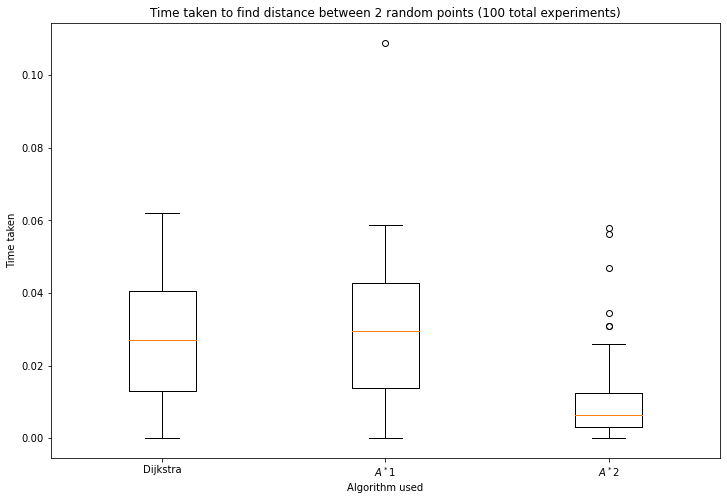

In [30]:
fig = plt.figure(figsize =(12, 8))
 
plt.boxplot([dijkstra_times, a_star_1_times, a_star_2_times])
#plt.yscale("log")
plt.xticks(ticks = range(1, 4), labels = ['Dijkstra', r'$A^* 1$',
                    r'$A^* 2$'])

plt.title("Time taken to find distance between 2 random points (100 total experiments)")
plt.xlabel("Algorithm used")
plt.ylabel("Time taken")

plt.show()

### Box plot of steps

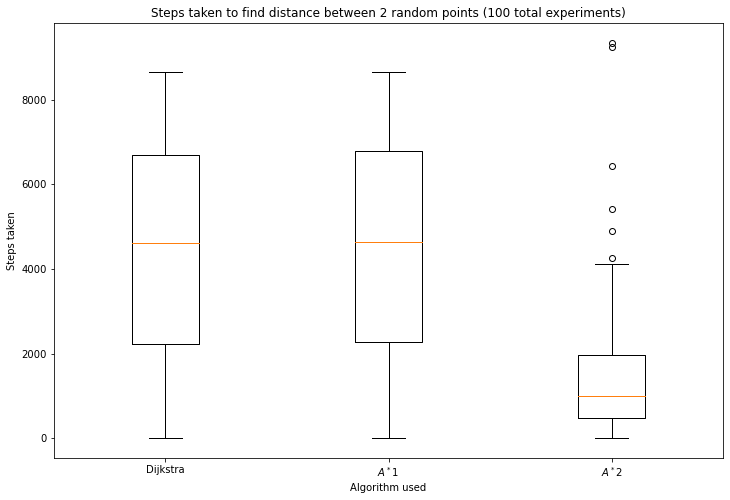

In [31]:
fig = plt.figure(figsize =(12, 8))
 
plt.boxplot([dijkstra_steps, a_star_1_steps, a_star_2_steps])
#plt.yscale("log")
plt.xticks(ticks = range(1, 4), labels = ['Dijkstra', r'$A^* 1$',
                    r'$A^* 2$'])

plt.title("Steps taken to find distance between 2 random points (100 total experiments)")
plt.xlabel("Algorithm used")
plt.ylabel("Steps taken")

plt.show()

### Dijkstra comparison (Time taken until the whole graph is analysed)

In [32]:
d_times = []

np.random.seed(1)

for i in range(N):
    start_row = gdf_data.sample()
    start_node = (start_row.start_node_x[0], start_row.start_node_y[0])
    pc = perf_counter()
    pq_dijkstra(graph, start_node, None)
    d_times.append(perf_counter() - pc)

In [33]:
print(f'Average time taken by Dijkstra: {np.average(np.array(d_times))} seconds')

Average time taken by Dijkstra: 0.04888657047998095 seconds


## NB! Dijkstra without priority queue took 157 seconds to go through the whole graph